# DeepRacer Local Training Logs Analysis
(Last updated 10/2022)
<br>
___

This is my logs analysis tool that I created so you can visualize the performance of your model in local training. 
Just click the **double arrow button >>** at the top to run all the cells.

This Notebook can be downloaded from [Github](https://github.com/nattliang/Deepracer-Local-Analysis). 

<u> The code generates the following graphs at the bottom of the notebook </u>:
- Average reward and progress during training & evaluation
- Lap completion percentage
- Lap times

# Import analysis_utils:

In [1]:
from analysis_utils import *

Looking for logs in: data/minio/bucket/rl-deepracer-1/metrics/
# of Episodes per Robomaker: 40


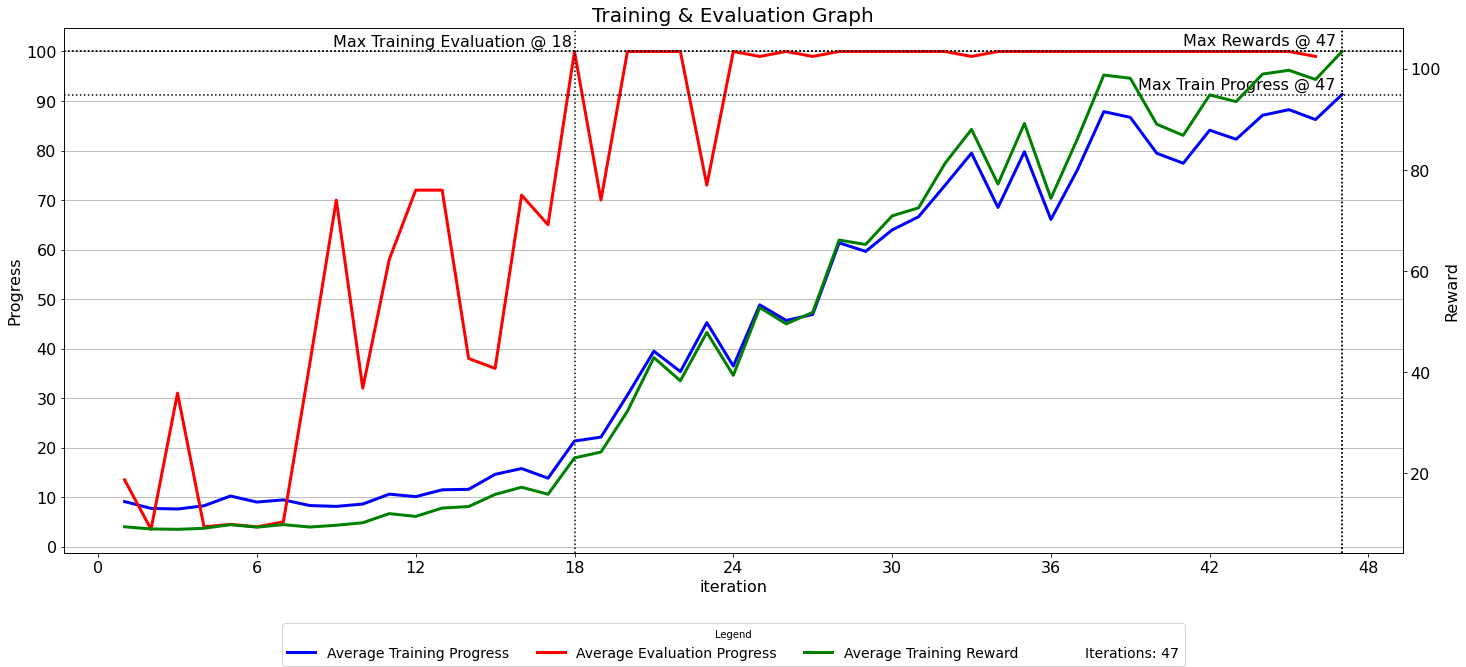

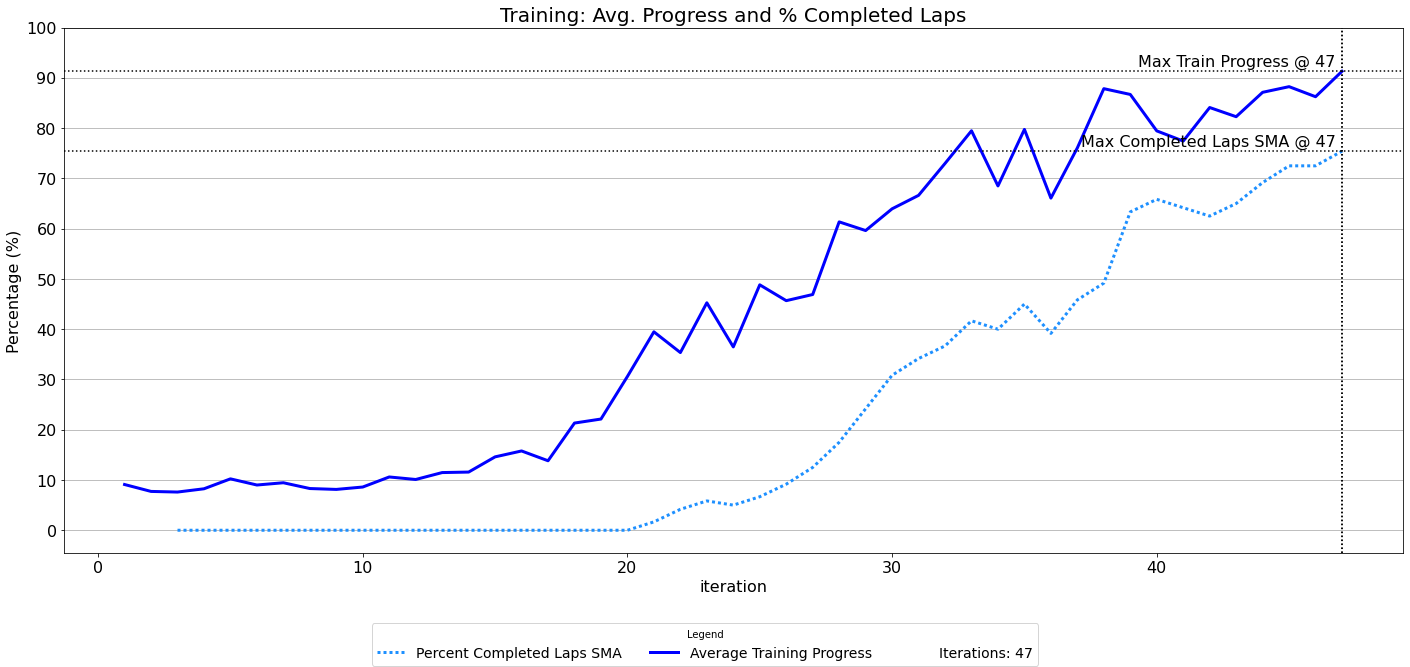

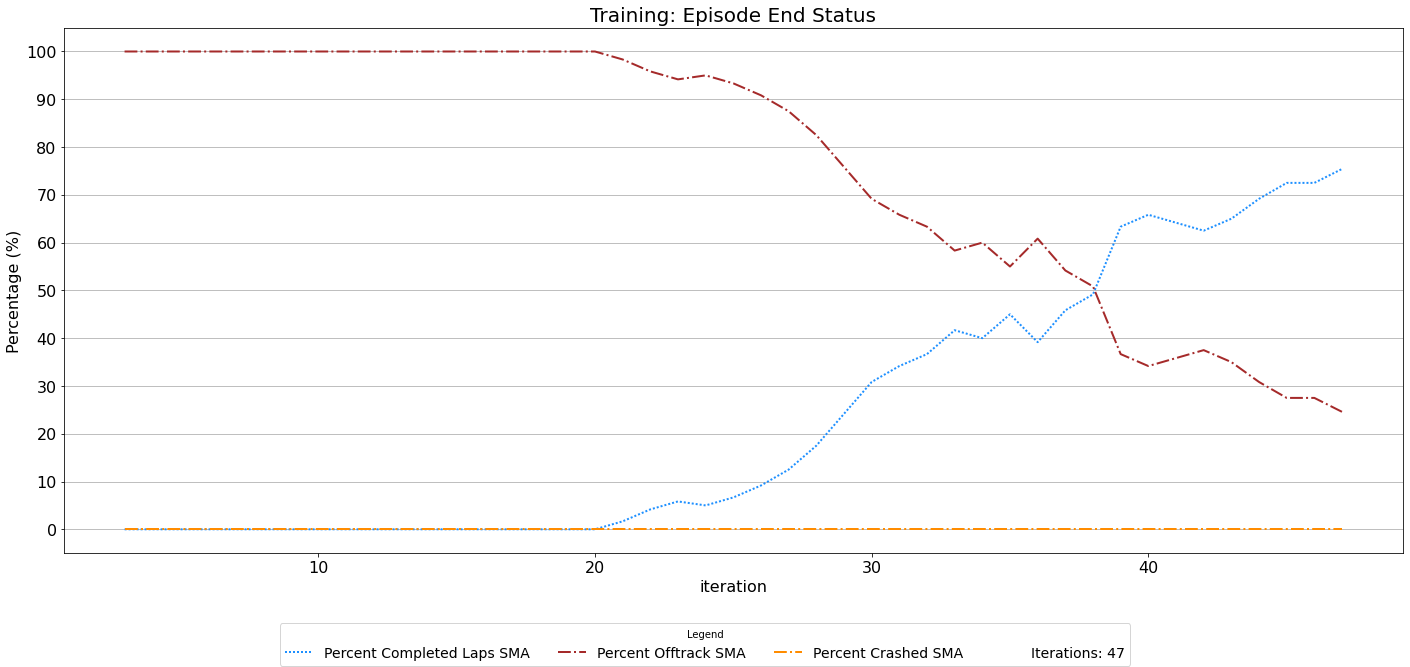

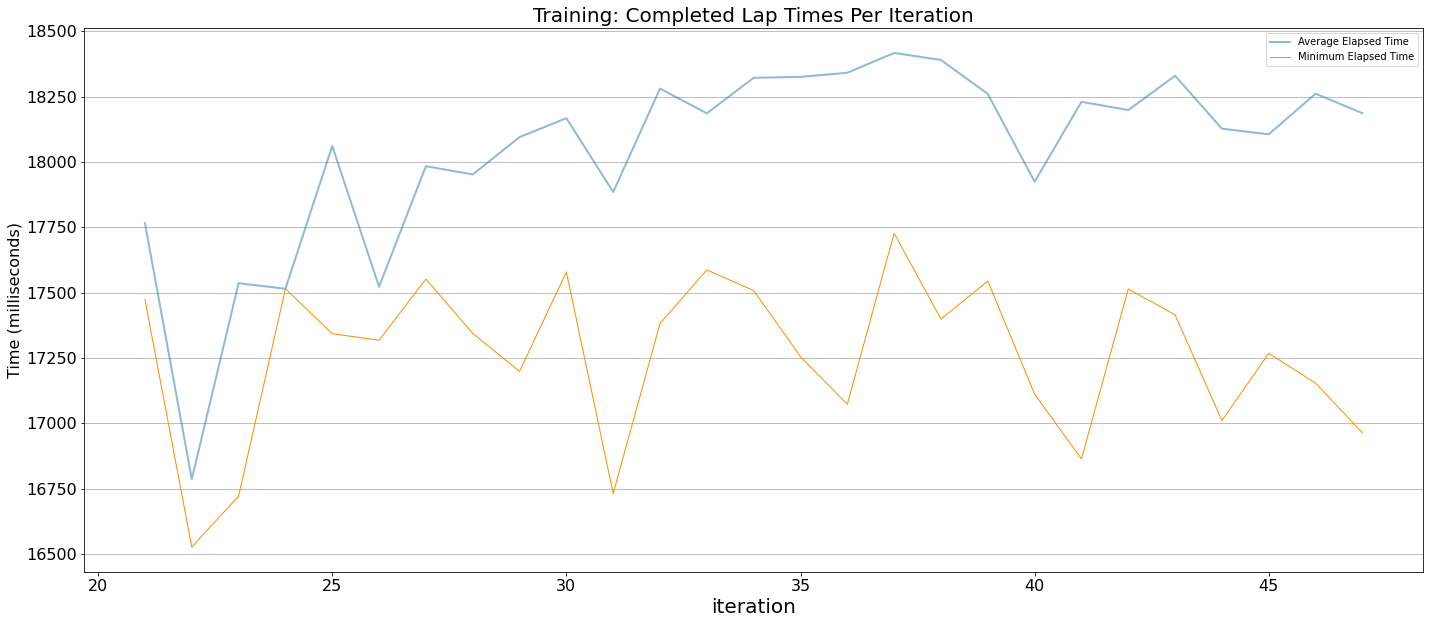

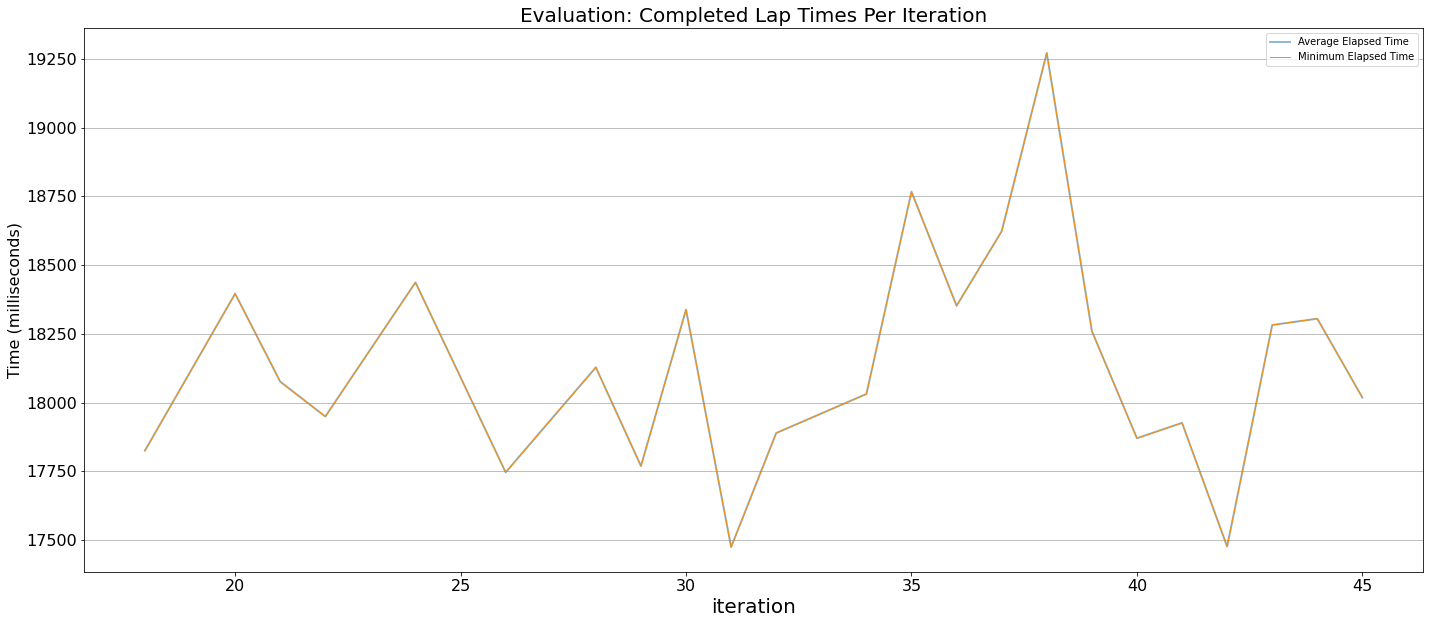

In [2]:
run_notebook()